In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio 
from osgeo import gdal
import json
import pandas as pd
import xarray as xr
import cdsapi
from datetime import datetime, timedelta
from time import time

In [2]:
def access_era5(time, day, year, month, plume_lat, plume_lon, save_path): 
    """
    ## Access ERA5 reanalysis data from CDSAPI (global)
    """
    
    # Plume max concentration plus the nearest pixels on a 0.25 x 0.25 degree scale
    plume_coords = [plume_lat,plume_lon, plume_lat+0.75, plume_lon+0.75, ]
    fname_ext = '.grib'
    fname = year + month + day + '_' + time + fname_ext
    fname = os.path.join(save_path, fname)
    
    # Retrieve ERA5 from Climate Data Store (CDS) API 
    c = cdsapi.Client()
    c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'grib',
        'day': day, 
        'time': time,
        'year': year,
        'month': month,
        'area': plume_coords,
        'variable': [
            '10m_u_component_of_wind',
        ],
    },
    fname)
    
    ds = xr.open_dataset(fname)
    df = ds.to_dataframe()
    u10_avg = np.nanmean(df['u10'])
    
    return u10_avg

def hour_round(time): 
    """
    ## Round a time string to nearest UTC hour
    """
    
    time_obj = datetime.strptime(time, '%H:%M:%S')
    nearest_hour = (time_obj + timedelta(minutes=30)).replace(minute=0, second=0)
    rounded_time = nearest_hour.strftime('%H:%M:%S')
    return rounded_time[0:-3]

In [3]:
def calc_ime(plume_arr, plume_path, plot = True): 
    """
    plume_arr: 2-D array of plume enhancement data [ppmm]
    plume_path: filepath to plume enhancement data
    
    ime: excess mass of CH4 in plume [kg]
    p_s: dimensions of EMIT pixel [m^2]
    """

    # Get number of non-NaN pixels in a plume 
    plume_only = plume_arr[plume_arr!=-9999]
    num_pixels = plume_only.size

    #      ppm(m)     L/m^3       mole/L      kg/mole
    k = (1.0/1e6)*(1000.0/1.0)*(1.0/22.4)*(0.01604/1.0) # scaling factor from ppmm to kg CH4

    # IME calculation 
    p_s = pixel_size(plume_path)
    ime = k * np.sum([mf*p_s for mf in plume_only])
    
    if plot: 
        plt.imshow(plume_arr)
        plt.show()
    
    return ime, p_s

def pixel_size(plume_path): 
    """
    plume_path: filepath to plume enhancement data
    
    p_s: dimensions of EMIT pixel [m^2]
    """
    
    proj_ds = gdal.Warp('', plume_path, dstSRS='EPSG:3857', format='VRT')
    transform_3857 = proj_ds.GetGeoTransform()
    xsize_m = transform_3857[1]
    ysize_m = transform_3857[5]
    p_s = np.abs(xsize_m * ysize_m)
    
    return p_s 

def calc_q(plume_arr, plume_path, u10): 
    """
    plume_arr: 2-D array of plume enhancement data [ppmm]
    plume_path: filepath to plume enhancement data
    u10: near surface windspeed from re-analysis data 
    
    q: hourly plume emissions [kgCH4/hr]
    ime: excess mass of CH4 in plume [kg]
    """
    
    ime, p_s = calc_ime(plume_arr, plume_path)
    plume_length = np.max(plume_arr.shape)*np.sqrt(p_s) # average length of plume [m] 
    
    q = (ime/plume_length) * u10
    return ime, q

## IME + Emissions Calcuations

In [4]:
# Path to delineated plume COGs 
plume_path = '/scratch/brodrick/methane/visions_delivery/'

# Path to plume metadata (.json) 
metadata_path = '/scratch/brodrick/methane/visions_delivery/combined_plume_metadata.json'

# Open plume metadata as nested json dict
f = open(metadata_path)
metadata = json.load(f)
plume_df = pd.json_normalize(metadata['features'])

# Remove duplicate plume metadata "Point" entries 
poly_df = plume_df[plume_df['geometry.type'] == 'Polygon']
plume_id_list = list(poly_df['properties.Plume ID'])
scene_fid_list = list(poly_df['properties.Scene FIDs'])
save_path = '/scratch/colemanr/emit-ghg/grib'

2023-09-05 14:59:09,599 INFO Welcome to the CDS
2023-09-05 14:59:09,601 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-09-05 14:59:10,010 INFO Request is completed
2023-09-05 14:59:10,012 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data5/adaptor.mars.internal-1693935024.112105-17407-1-da5aefa1-bfaf-41dd-88be-91517e7d8c3a.grib to /scratch/colemanr/emit-ghg/grib/20220810_07:00.grib (240)
2023-09-05 14:59:11,011 INFO Download rate 240.5/s                                                                                                      
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220810_07:00.grib.923a8.idx' older than GRIB file


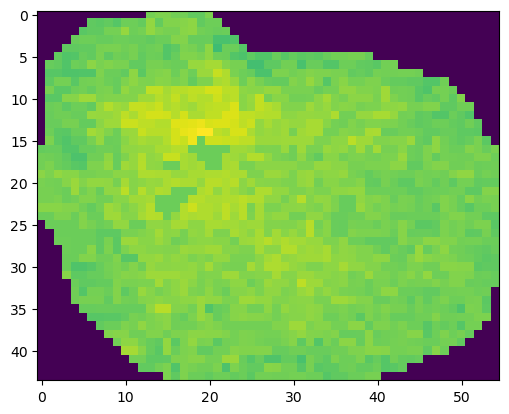

CH4_PlumeComplex-485
IME [kg]: 2465.027551580531
Q [kgCH4/hr]: 1.0378291074512764
Time [s]: 7.141739


2023-09-05 14:59:15,630 INFO Welcome to the CDS
2023-09-05 14:59:15,632 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-09-05 14:59:15,931 INFO Request is completed
2023-09-05 14:59:15,932 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data6/adaptor.mars.internal-1693935155.2191799-25511-14-1069a816-3194-45d4-ba2c-d40d7cdc54f2.grib to /scratch/colemanr/emit-ghg/grib/20220810_07:00.grib (240)
2023-09-05 14:59:17,103 INFO Download rate 205.1/s                                                                                                      
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220810_07:00.grib.923a8.idx' older than GRIB file


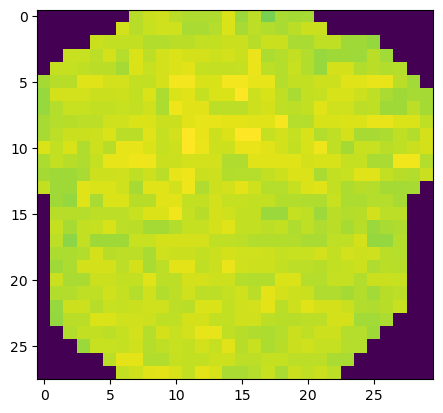

2023-09-05 14:59:17,640 INFO Welcome to the CDS
2023-09-05 14:59:17,642 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


CH4_PlumeComplex-486
IME [kg]: 722.1205400068364
Q [kgCH4/hr]: 1.6945313576518006
Time [s]: 2.12929


2023-09-05 14:59:17,943 INFO Request is completed
2023-09-05 14:59:17,944 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data2/adaptor.mars.internal-1693935160.645028-6550-8-fdbb9a12-c2e5-4df9-ace4-47ccf2166670.grib to /scratch/colemanr/emit-ghg/grib/20220810_07:00.grib (240)
2023-09-05 14:59:19,057 INFO Download rate 215.9/s                                                                                                      
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220810_07:00.grib.923a8.idx' older than GRIB file


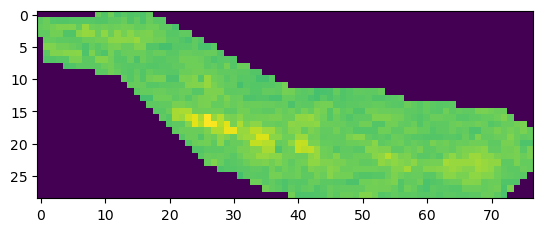

CH4_PlumeComplex-487
IME [kg]: 1149.6296948378822
Q [kgCH4/hr]: 1.484161080752599
Time [s]: 2.024902


2023-09-05 14:59:19,710 INFO Welcome to the CDS
2023-09-05 14:59:19,712 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-09-05 14:59:20,046 INFO Request is completed
2023-09-05 14:59:20,047 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data2/adaptor.mars.internal-1693935269.2913878-19656-18-a52f7b1a-da5b-4e75-bc38-fe5feba88c1e.grib to /scratch/colemanr/emit-ghg/grib/20220810_07:00.grib (240)
2023-09-05 14:59:21,228 INFO Download rate 203.5/s                                                                                                      
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220810_07:00.grib.923a8.idx' older than GRIB file


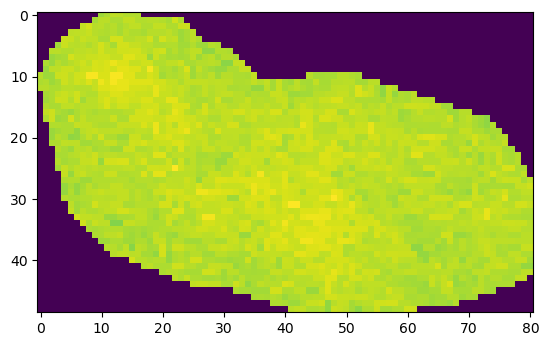

CH4_PlumeComplex-496
IME [kg]: 2020.599088055781
Q [kgCH4/hr]: 2.3898222027973057
Time [s]: 2.096637


2023-09-05 14:59:21,822 INFO Welcome to the CDS
2023-09-05 14:59:21,823 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-09-05 14:59:22,141 INFO Request is completed
2023-09-05 14:59:22,143 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data9/adaptor.mars.internal-1693935275.752459-23883-6-65dc34a7-e481-4ee6-bbbc-7672d0241cfe.grib to /scratch/colemanr/emit-ghg/grib/20220811_04:00.grib (240)
2023-09-05 14:59:23,324 INFO Download rate 203.4/s                                                                                                      
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220811_04:00.grib.923a8.idx' older than GRIB file


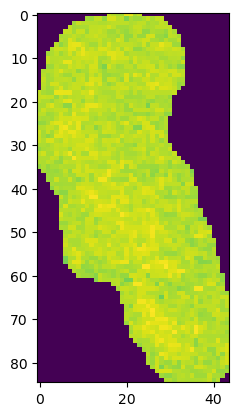

2023-09-05 14:59:23,824 INFO Welcome to the CDS
2023-09-05 14:59:23,825 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


CH4_PlumeComplex-490
IME [kg]: 1195.4889488972178
Q [kgCH4/hr]: -1.110971354271307
Time [s]: 2.076796


2023-09-05 14:59:24,122 INFO Request is completed
2023-09-05 14:59:24,124 INFO Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data4/adaptor.mars.internal-1693935287.1540644-13940-12-5de7b345-b3cf-4835-b3a3-c457498c5b07.grib to /scratch/colemanr/emit-ghg/grib/20220814_05:00.grib (240)
2023-09-05 14:59:25,314 INFO Download rate 201.9/s                                                                                                      
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220814_05:00.grib.923a8.idx' older than GRIB file


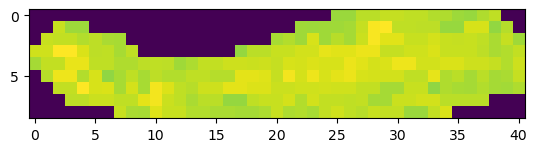

2023-09-05 14:59:25,810 INFO Welcome to the CDS
2023-09-05 14:59:25,811 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


CH4_PlumeComplex-491
IME [kg]: 178.93153575847555
Q [kgCH4/hr]: 0.497873597460812
Time [s]: 1.98357
Skipping CH4_PlumeComplex-492
Time [s]: 1.4e-05
Skipping CH4_PlumeComplex-493
Time [s]: 1.2e-05


2023-09-05 14:59:26,192 INFO Request is completed
2023-09-05 14:59:26,193 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data3/adaptor.mars.internal-1693935324.5272853-3242-6-7b50c7ea-06e9-4284-b145-a61c11657971.grib to /scratch/colemanr/emit-ghg/grib/20220815_04:00.grib (240)
2023-09-05 14:59:27,358 INFO Download rate 206.3/s                                                                                                      
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220815_04:00.grib.923a8.idx' older than GRIB file


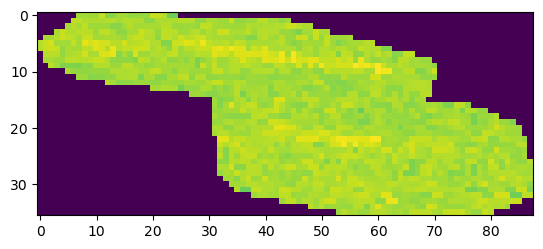

2023-09-05 14:59:27,889 INFO Welcome to the CDS
2023-09-05 14:59:27,891 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


CH4_PlumeComplex-494
IME [kg]: 671.7097713670157
Q [kgCH4/hr]: -0.4813833146248592
Time [s]: 2.058934


2023-09-05 14:59:28,119 INFO Request is completed
2023-09-05 14:59:28,120 INFO Downloading https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data7/adaptor.mars.internal-1693935452.1174219-6228-2-e06ff82e-5881-4143-8cf8-f722ef84b9e2.grib to /scratch/colemanr/emit-ghg/grib/20220815_08:00.grib (240)
2023-09-05 14:59:29,338 INFO Download rate 197.2/s                                                                                                      
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220815_08:00.grib.923a8.idx' older than GRIB file


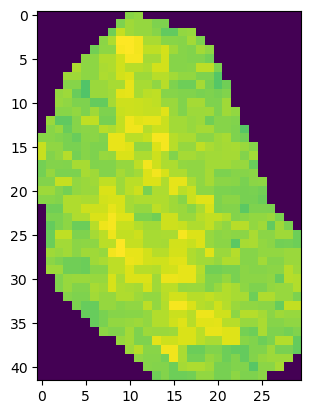

CH4_PlumeComplex-495
IME [kg]: 2145.8821062189263
Q [kgCH4/hr]: -1.4393318547808938
Time [s]: 2.010928


In [5]:
# Emissions calculation for all plumes on cluster 
for i in range(len(plume_id_list))[0:10]:
    
    start = datetime.now()
    
    plume_id = plume_id_list[i]
    scene_fid = scene_fid_list[i]
    
    if len(scene_fid) < 2: 
        for fid in scene_fid:
            curr_folder = os.path.join(fid[4:12], 'l2bch4plm')
            curr_file = fid + '_' + plume_id + '.tif'
            full_path = os.path.join(plume_path, curr_folder, curr_file)

            # Get plume metadata properties
            sub_df = poly_df[poly_df['properties.Plume ID'] == plume_id]
            obs = list(sub_df['properties.UTC Time Observed'])[0]
            day = obs[8:10]
            time = hour_round(obs[11:19])
            year = obs[0:4]
            month = obs[5:7]
            plume_lat = list(sub_df['properties.Latitude of max concentration'])[0]
            plume_lon = list(sub_df['properties.Longitude of max concentration'])[0]

            # Load plume as 2D array
            with rasterio.open(full_path, 'r') as ds: 
                plume_arr = ds.read().squeeze()

            # IME and Q calculations, get ERA5 u10 data from CDSAPI
            u10_avg = access_era5(time, day, year, month, plume_lat, plume_lon, save_path)
            ime, q = calc_q(plume_arr, full_path, u10_avg)
            print(plume_id)
            print('IME [kg]:', ime)
            print('Q [kgCH4/hr]:', q)
            
    else: # Ignore any plumes that cover multiple scenes 
        print('Skipping', plume_id)
        
    stop = datetime.now()
    print('Time [s]:', (stop-start).total_seconds())

### Experimental HRRR code

In [41]:
from herbie import Herbie

model_run_date = year + '-' + month + '-' + day + ' ' + time
model_name = 'hrrr'

H = Herbie(
    model_run_date,  # model run date
    model="hrrr",  # model name
    fxx=0,  # forecast lead time
)

# U and V wind at 10-m above ground
H.PRODUCTS
ds = H.xarray(":UGRD:10 m")

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Aug-18 07:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws


In [56]:
min_lat_hrrr = float(np.min(ds.latitude))
max_lat_hrrr = float(np.max(ds.latitude))
min_lon_hrrr = float(np.min(ds.longitude))
max_lon_hrrr = float(np.max(ds.longitude))

# Check to see if plume in CONUS/HRRR range 
hrrr_cond = min_lat_hrrr <= plume_lat <= max_lat_hrrr and min_lat_hrrr <= plume_lon <= max_lat_hrrr

if hrrr_cond: 
    # Find average windspeed around plume 